In [1]:
# Check if NVIDIA GPU is enabled
!nvidia-smi

Wed May 26 06:29:04 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

1) Clone, configure & compile Darknet

In [2]:

# Clone
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 15050, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 15050 (delta 16), reused 34 (delta 14), pack-reused 15002
Receiving objects: 100% (15050/15050), 13.45 MiB | 20.46 MiB/s, done.
Resolving deltas: 100% (10214/10214), done.


In [3]:
# Configure
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile

/content/darknet


In [4]:
# Compile
!make

mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:935:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1136:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
             if (iteration_old == 0)
             ^~
./src/image_


2) Configure yolov3.cfg file

In [5]:
# Make a copy of yolov3.cfg
!cp cfg/yolov3.cfg cfg/yolov3_training.cfg


In [6]:

# Change lines in yolov3.cfg file
!sed -i 's/batch=1/batch=64/' cfg/yolov3_training.cfg
!sed -i 's/subdivisions=1/subdivisions=16/' cfg/yolov3_training.cfg
!sed -i 's/max_batches = 500200/max_batches = 4000/' cfg/yolov3_training.cfg
!sed -i '610 s@classes=80@classes=2@' cfg/yolov3_training.cfg #since 2 classes
!sed -i '696 s@classes=80@classes=2@' cfg/yolov3_training.cfg
!sed -i '783 s@classes=80@classes=2@' cfg/yolov3_training.cfg
!sed -i '603 s@filters=255@filters=21@' cfg/yolov3_training.cfg
!sed -i '689 s@filters=255@filters=21@' cfg/yolov3_training.cfg
!sed -i '776 s@filters=255@filters=21@' cfg/yolov3_training.cfg

for n number of classes

max_batches = 2000*n

filters = (n+5)*3

3) Create .names and .data files

In [15]:
!echo -e 'Car\nLiscence_Plate' > data/obj.names
!echo -e 'classes= 2\ntrain  = /content/darknet/data/obj/train.txt\nvalid  = /content/darknet/data/obj/test.txt\nnames = /content/darknet/data/obj.names\nbackup = /content/drive/MyDrive/yolov3' > data/obj.data

4) Save yolov3_training.cfg and obj.names files in Google drive

In [16]:
!cp cfg/yolov3_training.cfg /content/drive/MyDrive/yolov3/yolov3_testing.cfg
!cp data/obj.names /content/drive/MyDrive/yolov3/classes.txt

5) Create a folder and unzip image dataset

In [9]:
!mkdir data/obj
!unzip /content/drive/MyDrive/yolov3/image.zip -d data/obj

Archive:  /content/drive/MyDrive/yolov3/image.zip
  inflating: data/obj/Cars0.png      
  inflating: data/obj/Cars0.txt      
  inflating: data/obj/Cars1.png      
  inflating: data/obj/Cars1.txt      
  inflating: data/obj/Cars10.png     
  inflating: data/obj/Cars10.txt     
  inflating: data/obj/Cars100.png    
  inflating: data/obj/Cars100.txt    
  inflating: data/obj/Cars101.png    
  inflating: data/obj/Cars101.txt    
  inflating: data/obj/Cars102.png    
  inflating: data/obj/Cars102.txt    
  inflating: data/obj/Cars103.png    
  inflating: data/obj/Cars103.txt    
  inflating: data/obj/Cars104.png    
  inflating: data/obj/Cars104.txt    
  inflating: data/obj/Cars106.png    
  inflating: data/obj/Cars106.txt    
  inflating: data/obj/Cars107.png    
  inflating: data/obj/Cars107.txt    
  inflating: data/obj/Cars108.png    
  inflating: data/obj/Cars108.txt    
  inflating: data/obj/Cars109.png    
  inflating: data/obj/Cars109.txt    
  inflating: data/obj/Cars11.png     


In [ ]:
#just to check---this block not required
import glob
path = '/content/darknet/data/obj/'
for i in glob.glob("/content/darknet/data/obj/*.png"):
  temp = path+i.split('/')[-1]
  print(temp)

Create train.txt and test.txt

In [11]:
import os
import random

imgspath = '/content/darknet/data/obj/' #path to images
path = '/content/darknet/data/obj/'
images = []
for i in glob.glob("/content/darknet/data/obj/*.png"):
  temp = path+i.split('/')[-1]
  images.append(temp)
# train and test split... adjust it if necessary
trainlen = round(len(images)*.80)
testlen = round(len(images)*.20)
print(trainlen,testlen)
#print('total, train, test dataset size -',trainlen+testlen,trainlen,testlen)
random.shuffle(images)
test = images[:testlen]
train = images[testlen:]

#!mkdir '/content/darknet/data/obj/'

with open('/content/darknet/data/obj/train.txt', 'w') as f:
    for item in train:
        f.write("%s\n" % item)
with open('/content/darknet/data/obj/test.txt', 'w') as f:
    for item in test:
        f.write("%s\n" % item)

273 68


In [12]:
import os
len(os.listdir('/content/darknet/data/obj'))/2#my images count i.e 342

343.0

In [ ]:
'''import glob
images_list = glob.glob("data/obj/*.png")
with open("data/train.txt", "w") as f:
    f.write("\n".join(images_list))'''

7) Download pre-trained weights for the convolutional layers file

In [ ]:
!wget https://pjreddie.com/media/files/darknet53.conv.74

--2021-05-25 08:56:36--  https://pjreddie.com/media/files/darknet53.conv.74
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 162482580 (155M) [application/octet-stream]
Saving to: ‘darknet53.conv.74’

darknet53.conv.74   100%[===================>] 154.96M  56.0MB/s    in 2.8s    

2021-05-25 08:56:39 (56.0 MB/s) - ‘darknet53.conv.74’ saved [162482580/162482580]



8) Start training

In [ ]:
!./darknet detector train data/obj.data cfg/yolov3_training.cfg darknet53.conv.74 -dont_show
# Uncomment below and comment above to re-start your training from last saved weights
#!./darknet detector train data/obj.data cfg/yolov3_training.cfg /content/drive/MyDrive/yolov3/yolov3_training_last.weights -dont_show

In [ ]:
!./darknet detector train data/obj.data cfg/yolov3_training.cfg /content/drive/MyDrive/yolov3/yolov3_training_last.weights -dont_show

 CUDA-version: 11000 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
yolov3_training
 0 : compute_capability = 370, cudnn_half = 0, GPU: Tesla K80 
net.optimized_memory = 0 
mini_batch = 4, batch = 64, time_steps = 1, train = 1 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Sh

**PREDICTION**

In [17]:
import cv2
import numpy as np
def predict_bbox(img_num):
    net = cv2.dnn.readNet('/content/drive/MyDrive/yolov3/yolov3_training_last.weights', '/content/drive/MyDrive/yolov3/yolov3_testing.cfg')

    classes = []
    with open("/content/drive/MyDrive/yolov3/classes.txt", "r") as f:
        classes = f.read().splitlines()

    #cap = cv2.VideoCapture('video4.mp4')
    #cap = 'test_images/<your_test_image>.jpg'
    font = cv2.FONT_HERSHEY_PLAIN
    colors = np.random.uniform(0, 255, size=(100, 3))

    #while True:
    #_, img = cap.read()
    
    with open("/content/darknet/data/obj/test.txt", "r") as f:
      test_img = f.read().splitlines()
    
    img = cv2.imread(test_img[img_num])
    height, width, _ = img.shape

    blob = cv2.dnn.blobFromImage(img, 1/255, (416, 416), (0,0,0), swapRB=True, crop=False)
    net.setInput(blob)
    output_layers_names = net.getUnconnectedOutLayersNames()
    layerOutputs = net.forward(output_layers_names)

    boxes = []
    confidences = []
    class_ids = []

    for output in layerOutputs:
        for detection in output:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.2:
                center_x = int(detection[0]*width)
                center_y = int(detection[1]*height)
                w = int(detection[2]*width)
                h = int(detection[3]*height)

                x = int(center_x - w/2)
                y = int(center_y - h/2)

                boxes.append([x, y, w, h])
                confidences.append((float(confidence)))
                class_ids.append(class_id)

    indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.2, 0.4)

    if len(indexes)>0:
        for i in indexes.flatten():
            x, y, w, h = boxes[i]
            label = str(classes[class_ids[i]])
            confidence = str(round(confidences[i],2))
            color = colors[i]
            cv2.rectangle(img, (x,y), (x+w, y+h), color, 2)
            cv2.putText(img, label + " " + confidence, (x, y+20), font, 1, (255,255,255), 2)

    from google.colab.patches import cv2_imshow
    cv2_imshow(img)
    #cv2.imshow('Image', img)
    '''key = cv2.waitKey(1)
    if key==27:
        break
'''
    #cap.release()
    cv2.destroyAllWindows()

In [23]:
#the file we created test.txt has 68 images which we will use to predict
with open("/content/darknet/data/obj/test.txt", "r") as f:
    test_img = f.read().splitlines()
print('total number of images in test data: ',len(test_img))

total number of images in test data:  68


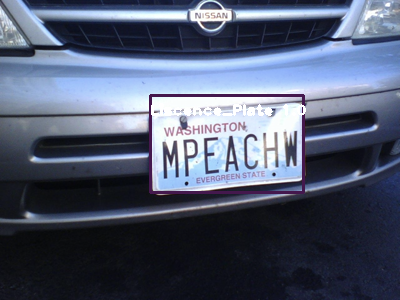

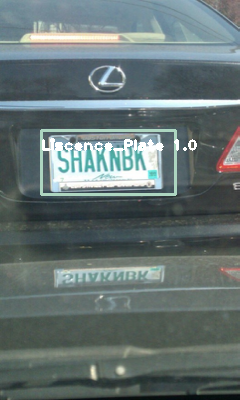

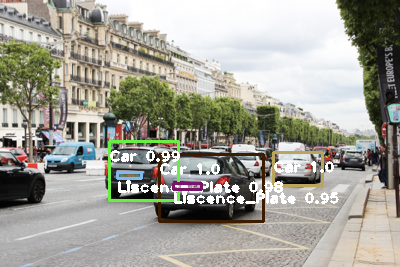

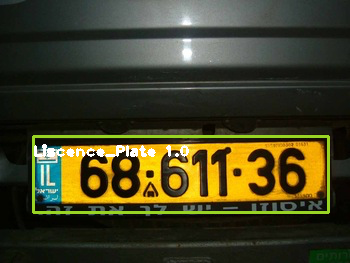

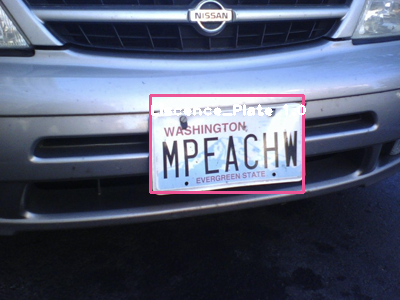

In [24]:
#use any number from 0 to 68 in the below code to predict images
x= np.random.randint(0,68,5)
for i in x:
  predict_bbox(i)